In [1]:
import random
import itertools
import array
import sys
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Process
from IPython.display import clear_output

In [27]:
ROSETTA = [4,8,14]
SAFE = [0,1,2,3,4,13,14,15]
CENTRAL_ROSETTA = [8]

class Player():
  
    def __init__(self, name='black', asc='■'):
        self.name = name
        self.ascii = asc
        
    def choose_move(self, game, movement):
        pass
        
    def learn(self, win=True):
        pass
      
    def empty_history(self):
        pass
        
class RandomPlayer(Player):
  
    def choose_move(self, game, movement):
        valid_moves = game.valid_movements(movement)
        piece = random.choice(valid_moves)
        return piece
      
class SimplePlayer(Player):
  
    def choose_move(self, game, movement):
        valid_moves = game.valid_movements(movement)
        piece = valid_moves[0]
        return piece
      
class MaxPlayer(Player):
  
    def choose_move(self, game, movement):
        valid_moves = game.valid_movements(movement)
        piece = max(valid_moves)
        return piece
      
class AggressiveMaxPlayer(Player):
  
    def choose_move(self, game, movement):
        valid_moves = game.valid_movements(movement)
        occupied = [move for move in valid_moves 
                      if game.is_occupied_by_enemy(move+movement, self) and
                         move not in SAFE]
        if occupied:
            return max(occupied)
        else:
            return max(valid_moves)
          
class RosettaLoverPlayer(Player):
  
    def choose_move(self, game, movement):
        valid_moves = game.valid_movements(movement)
        to_rosettas = [piece for piece in valid_moves
                          if piece+movement in ROSETTA]
        not_in_rosetta = [piece for piece in valid_moves
                          if piece not in CENTRAL_ROSETTA]
        if to_rosettas:
            return max(to_rosettas)
        elif not_in_rosetta:
            return max(not_in_rosetta)
        else:
            return max(valid_moves)

class QPlayer(Player):
  
    def __init__(self, rate, states=None, name='white', asc='q'):
        self.name = name
        self.learning_rate = rate
        if not states:
            self.states = {}
        else:
            self.states = states
        self.last_states = []
        self.learning = False
        self.ascii = asc
        self.enemy_states = []
    
    def choose_move(self, game, movement):
        previous_state = game.get_state(player=self)
        self.enemy_states.append(transpose_state(previous_state))
        
        valid_moves = game.valid_movements(movement)        
        future_states = [game.get_sim_state(move, movement) for move in valid_moves]
        state, piece = self.get_best_piece_for_state(future_states, valid_moves)
        
        self.last_states.append(state)
        return piece
      
    def learn(self, win=True):
        if win:
            for i, state in enumerate(self.last_states):
                coef = i/len(self.last_states)
                self.buff(state, coef)
#             for i, state in enumerate(self.enemy_states):
#                 coef = i/len(self.enemy_states)
#                 self.nerf(state, coef)
        else:
            for i, state in enumerate(self.last_states):
                coef = i/len(self.last_states)
                self.nerf(state, coef)
#             for i, state in enumerate(self.enemy_states):
#                 coef = i/len(self.enemy_states)
#                 self.buff(state, coef)
        self.last_states = []
        self.enemy_states = []
    
    def buff(self, state, coef):
        if state in self.states:
            self.states[state] = self.states[state]*(1+self.learning_rate*coef)
        else:
            self.states[state] = 0.5*(1+self.learning_rate*coef)
    
    def nerf(self, state, coef):
        if state in self.states:
            self.states[state] = self.states[state]/(1+self.learning_rate*coef)
        else:
            self.states[state] = 0.5/(1+self.learning_rate*coef)
            
    def set_learning(self, learning):
        self.learning = learning
        
    def get_best_piece_for_state(self, states, moves):
        indexes = [i for i in range(len(moves))]
        values = [self.states[state] if state in self.states else 0.5
                  for state in states]
        
        if(self.learning):
            index = random.choices(indexes, weights=values)[0]
            piece = moves[index]
            best_state = states[index]
        else:
            best_state = states[values.index(max(values))]
            best_value_indexes = [i for i in range(len(values)) if values[i] == max(values)]
            piece = max([moves[i] for i in best_value_indexes])
        return best_state, piece
      
    def set_learning(self, learn):
        self.learning = learn
        
    def empty_history(self):
        self.last_states = []
        self.enemy_states = []
       

class Piece():
    def __init__(self, player):
        self.player = player
        self.cell = 0
    
    def reset_cell(self):
        self.cell = 0
        
    def move(self, movement):
        self.cell = self.cell + movement


class Ur():
    def __init__(self, p1, p2, log=False):
        self.board = new_board()
        self.p1 = p1
        self.p2 = p2
        self.pieces = {}
        self.turn = itertools.cycle([self.p1, self.p2])
        self.current_turn = next(self.turn)
        self.moves = []
        self.logging = log
    
    def start_board(self):
        self.board = new_board()
        self.pieces[self.p1] = [Piece(self.p1) for i in range(6)]
        self.pieces[self.p2] = [Piece(self.p2) for i in range(6)]
        self.board[0] = self.pieces[self.p1] + self.pieces[self.p2]
        self.turn = itertools.cycle([self.p1, self.p2])
        self.current_turn = next(self.turn)
        self.moves = []
        
    def is_movement_valid(self, piece, movement):
        new_cell = piece.cell + movement
        if new_cell == 15:
            return True
        elif new_cell > 15:
            return False
        elif new_cell in SAFE:
            return not self.is_occupied_by_ally(new_cell, piece.player)
        else:
            return not self.is_occupied_by_ally(new_cell, piece.player)
        
    def valid_movements(self, movement):
        moves = [piece.cell for piece in self.pieces[self.current_turn]
                if self.is_movement_valid(piece, movement)]
        moves = list(set(moves))
        return moves
        
    def player_move(self):
        movement = roll_dice()
        player = self.current_turn
        if movement == 0:
            self.change_turn()
        valid_moves = self.valid_movements(movement)
        if valid_moves:
            piece_cell = player.choose_move(self, movement)
            self.move(piece_cell, movement)
        if(self.logging):
            print(player.ascii, movement)
            self.print_state()
    
    def move(self, piece_cell, movement):
        piece = self.get_piece_in_cell(piece_cell, self.current_turn)
        if movement == 0:
            return
        new_cell = piece.cell + movement
        self.board[piece.cell].remove(piece)        
        piece.move(movement)
        
        if new_cell not in SAFE:
            for piece_to_reset in self.board[new_cell]:
                piece_to_reset.reset_cell()
                self.board[0].append(piece_to_reset)
                if self.logging:
                    print(self.current_turn.ascii, "eats in", new_cell)
            self.board[new_cell] = []
        
        self.board[piece.cell].append(piece)
        if piece.cell not in ROSETTA:
            self.change_turn()
        self.moves.append((piece.player, piece.cell - movement, piece.cell))
        
    def get_piece_in_cell(self, cell, player):
        for piece in self.pieces[player]:
            if piece.cell == cell:
                return piece
        return None
    
    def is_occupied(self, cell):
        return len(self.board[cell]) > 0
    
    def is_occupied_by_enemy(self, cell, player):
        for piece in self.board[cell]:
            if piece.player != player:
                return True
        return False
          
    def is_occupied_by_ally(self, cell, player):
        for piece in self.board[cell]:
            if piece.player == player:
                return True
        return False
    
    def change_turn(self):
        self.current_turn = next(self.turn)
            
    def print_state(self):
        print([[piece.player.ascii for piece in self.board[cell]] for cell in range(0,1)])
        print([[piece.player.ascii for piece in self.board[cell]] for cell in range(1,5)])
        print([[piece.player.ascii for piece in self.board[cell]] for cell in range(5,13)])
        print([[piece.player.ascii for piece in self.board[cell]] for cell in range(13,15)])
        print([[piece.player.ascii for piece in self.board[cell]] for cell in range(15,16)])
        print('===============================================')
        
    def other_player(self, player):
        if self.p1 == player:
            return self.p2
        else:
            return self.p1
        
    def get_sim_state(self, cell, movement):
        player = self.current_turn
        pieces_current = [piece.cell for piece
                                 in self.pieces[player]]
        pieces_other = [piece.cell for piece
                               in self.pieces[self.other_player(player)]]
        
        for i, old_cell in enumerate(pieces_current):
            if old_cell == cell:
                pieces_current[i] = old_cell+movement
                break
        for i, old_cell in enumerate(pieces_other):
            if old_cell == cell+movement:
                pieces_other[i] = 0
                break
        pieces_current.sort()
        pieces_other.sort()
        i = 1
        res = 0
        for cell in pieces_other + pieces_current:
          res += cell*i
          i *= 16
        return hex(res)
        

    def get_state(self, player):
        pieces_1 = sorted([piece.cell for piece in self.pieces[self.p1]])
        pieces_2 = sorted([piece.cell for piece in self.pieces[self.p2]])
        if player == self.p2:
            pieces = pieces_2 + pieces_1
        else:
            pieces = pieces_1 + pieces_2
        #print(pieces)
        i = 1
        res = 0
        for cell in pieces:
          res += cell*i
          i *= 16
        return hex(res)
        
    def is_ended(self):
        p1 = [1 for piece in self.pieces[self.p1] if piece.cell == 15]
        p2 = [1 for piece in self.pieces[self.p2] if piece.cell == 15]
        return sum(p1) == 6 or sum(p2) == 6
    
    def winner(self):
        p1 = [1 for piece in self.pieces[self.p1] if piece.cell == 15]
        p2 = [1 for piece in self.pieces[self.p2] if piece.cell == 15]
        if sum(p1) == 6:
            return self.p1
        elif sum(p2) == 6:
            return self.p2
        else:
            return None
        
def get_key_of_max_value(d):
    mx = max(d.values())
    keys = [k for k, v in d.items() if v == mx]
    return max(keys)

def new_board():
    board = {
        0 : [],
        1 : [], 2 : [], 3 : [], 4 : [],
        5 : [], 6 : [], 7 : [], 8 : [], 9 : [], 10 : [], 11 : [], 12 : [],
        13 : [], 14 : [],
        15 : []
    }
    return board

def transpose_state(state):
    state = int(state, 16)
    player_two_state = state % 0x1000000
    player_one_state = state  // 0x1000000
    return hex(player_two_state * 0x1000000 + player_one_state)
  
def roll_dice():
    dice = [random.randint(1,6) for i in range(4)]
    marks = [1 for d in dice if d > 3]
    return sum(marks)
  
def train_player(p1, p2, times):
    game = Ur(p1, p2)
    for i in range(times):
        game.start_board()
        while not game.is_ended():
            game.player_move()
        if(game.winner() == p1):
            p1.learn(win=True)
            p2.learn(win=False)
        else:
            p1.learn(win=False)
            p2.learn(win=True)
  
def test_player(p1, p2, times):
    game = Ur(p1, p2)
    
    p1_wins_tot = 0
    p2_wins_tot = 0
    p1_wins = 0
    p2_wins = 0
    for i in range(times):
        game.start_board()
        while not game.is_ended():
            game.player_move()
        if(game.winner() == p1):
            p1_wins += 1
            p1_wins_tot += 1
        else:
            p2_wins += 1
            p2_wins_tot += 1
        p1.empty_history()
        p2.empty_history()

    return p1_wins / (p1_wins+p2_wins)

def train(times=2):
    #pl2 = MaxPlayer(name='Max')
    pl3 = RandomPlayer(name='Random')
    #pl5 = AggressiveMaxPlayer(name='AMax')
    #pl6 = RosettaLoverPlayer(name='Rosetta')
    for i in range(times):
        qp1.set_learning(True)
        #train_player(qp1, qp2, 200)
        #train_player(qp1, pl2, 2000)
        train_player(qp1, pl3, 20000)
        #train_player(qp1, pl5, 2000)
        #train_player(qp1, pl6, 2000)

        qp1.set_learning(False)
        #p = test_player(qp1, qp2, 1000)
        #m = test_player(qp1, pl2, 1000)
        r = test_player(qp1, pl3, 1000)
        #am = test_player(qp1, pl5, 1000)
        #rl = test_player(qp1, pl6, 1000)
        #qp_res.append(p)
        #m_res.append(m)
        r_res.append(r)
        #am_res.append(am)
        #rl_res.append(rl)

        clear_output()

        data = {'max':r_res}
        #data = {'max':m_res, 'rnd':r_res, 'agg':am_res, 'ros':rl_res, 'qp':qp_res}
        pd.DataFrame(data).plot()
        plt.show()
        
def run_parallel(processes, function):
    proc = []
    for i in range(processes):
        p = Process(target=function)
        p.start()
        proc.append(p)
    for p in proc:
        p.join()

In [28]:
states = {'test':0.1}
qp1 = QPlayer(0.2)
qp2 = QPlayer(1)

m_res = []
r_res = []
am_res = []
rl_res = []
qp_res = []

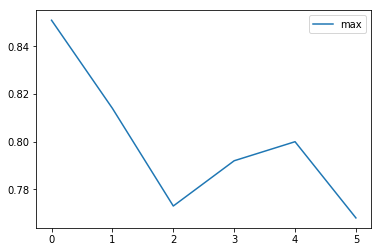

In [ ]:
train(350)

In [ ]:
data = {'max':m_res, 'rnd':r_res, 'agg':am_res, 'ros':rl_res, 'qp2':qp_res}
pd.DataFrame(data).plot()
plt.show()

In [23]:
l = sorted([ (qp1.states[key], key) for key in qp1.states ])
l.reverse()
l

[(18033048.462815642, '0xffffffffffa0'),
 (2509098.6355307684, '0xffffffffffc0'),
 (1748512.4466409453, '0xffffffffff60'),
 (712529.0236039156, '0xffffffffffb0'),
 (593958.1626763237, '0xffffffffff90'),
 (415745.6409626135, '0xffffffffff70'),
 (118752.9374471051, '0xffffffffffd0'),
 (98873.3348048, '0xffffffffff50'),
 (5485.895716910551, '0xfffffeffff70'),
 (2296.057086776098, '0xffffffffff30'),
 (1357.9309562066637, '0xfffffeffffa0'),
 (683.3824709642889, '0xfffffeffff90'),
 (545.2709401154669, '0xffffffffff20'),
 (541.6892144737883, '0xfffffffffb00'),
 (316.06085608574637, '0xfffffffffc00'),
 (315.9863553780062, '0xfffffffff900'),
 (315.913411303808, '0xfffffffffa00'),
 (137.41556374123135, '0xfffffeffff60'),
 (113.3050969977235, '0xfffffeffff50'),
 (97.75369781516714, '0xfffffefffff7'),
 (90.1031386403195, '0xfffffffff700'),
 (81.52674899050824, '0xfffffeffff30'),
 (75.65789657530777, '0xffffffffff00'),
 (75.26582452739355, '0xfffffffffd00'),
 (68.55104878837517, '0xfffffefffff9'),


In [ ]:
game = Ur(qp1, qp2)
game.start_board()
#for i in range(100):
while not game.is_ended():
    game.player_move()
    print(game.get_state())